In [371]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

#表示するテーブルの最大行と最大列を指定
pd.options.display.max_columns = 100
pd.options.display.max_rows = 999

seed = 42
# 乱数初期化
random.seed(seed)
np.random.seed(seed)

# データの読み込み
train = pd.read_csv('src/train.csv', index_col=0)
test = pd.read_csv('src/test.csv', index_col=0)
sample_submit = pd.read_csv('src/sample_submit.csv')

In [372]:
# 訓練データの欠損値の個数をカウント
print('train data')
print(train.isnull().sum())

train data
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    4
disease     0
dtype: int64


In [373]:
# テストデータの欠損値の個数をカウント
print('test data')
print(test.isnull().sum())

test data
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
dtype: int64


In [374]:
# データ処理のためtrainとtestを結合
train_data = pd.concat([train, test])
print('trainサイズ:', len(train))
print('testサイズ:', len(test))
print('train_dataサイズ:', len(train_data))

trainサイズ: 891
testサイズ: 382
train_dataサイズ: 1273


In [375]:
train_data.dtypes

Age           int64
Gender       object
T_Bil       float64
D_Bil       float64
ALP         float64
ALT_GPT     float64
AST_GOT     float64
TP          float64
Alb         float64
AG_ratio    float64
disease     float64
dtype: object

In [376]:
# オブジェクトカラムをラベルエンコーディング
object_columns = train_data.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
for column in object_columns:
    train_data[column] = le.fit_transform(train_data[column])
    # train[column] = train[column].astype('cateogyr')
train_data[object_columns] = train_data[object_columns].astype('category')
train_data.dtypes

Age            int64
Gender      category
T_Bil        float64
D_Bil        float64
ALP          float64
ALT_GPT      float64
AST_GOT      float64
TP           float64
Alb          float64
AG_ratio     float64
disease      float64
dtype: object

In [405]:
#ハイパーパラメータのチューニング
import optuna
from sklearn.metrics import mean_squared_error

# MeanF1スコアを格納するリスト
AUC_scores = []

X = train_data.drop('disease', axis=1).iloc[: len(train)]
y = train_data['disease'].iloc[: len(train)]

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, shuffle=True,
                                                  train_size=0.7,
                                                  random_state=seed,
                                                  stratify=y)


def objective(trial):
    params = {
        'random_seed': seed,
        'objective':'binary', # 'binary',
        'verbosity': -1,
        'metric': trial.suggest_categorical('metric', ['auc', 'binary_logloss', 'binary_error']), #'multy_logloss',
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'max_bin': trial.suggest_int('max_bin', 255, 500),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
    }

    train_lgb = lgb.Dataset(X_train, label=y_train)
    val_lgb = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(params, train_lgb,
                      valid_sets=[train_lgb, val_lgb],
                      num_boost_round=1000,
                      # callbacks=[lgb.early_stopping(stopping_rounds=10,
                      #                               verbose=False), lgb.log_evaluation(100)],
                      )

    y_pred_valid_prob = model.predict(X_val, num_iteration=model.best_iteration)
    # y_pred_valid = np.where(y_pred_valid_prob < 0.5, 0, 1)
    # score = np.sqrt(mean_squared_error(y_val, y_pred_valid_prob))
    score = roc_auc_score(y_val, y_pred_valid_prob)
    return score


study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=1000)
optimized_params = study.best_params
print(optimized_params)

[I 2024-05-02 11:04:21,301] A new study created in memory with name: no-name-1ab8bc70-2a1a-4991-b513-247049521f8c
[I 2024-05-02 11:04:23,294] Trial 0 finished with value: 0.9095317725752509 and parameters: {'metric': 'binary_logloss', 'learning_rate': 0.5990598257128396, 'feature_fraction': 0.24041677639819287, 'num_leaves': 41, 'bagging_fraction': 0.4348501673009197, 'bagging_freq': 7, 'max_bin': 402, 'lambda_l1': 0.02358594058414266, 'lambda_l2': 1.5320059381854043e-08, 'min_data_in_leaf': 49}. Best is trial 0 with value: 0.9095317725752509.
[I 2024-05-02 11:04:24,727] Trial 1 finished with value: 0.9467670011148271 and parameters: {'metric': 'auc', 'learning_rate': 0.18422110534358038, 'feature_fraction': 0.37381801866358394, 'num_leaves': 135, 'bagging_fraction': 0.6591670111852694, 'bagging_freq': 3, 'max_bin': 405, 'lambda_l1': 1.8007140198129195e-07, 'lambda_l2': 4.258943089524393e-06, 'min_data_in_leaf': 21}. Best is trial 1 with value: 0.9467670011148271.
[I 2024-05-02 11:04:2

{'metric': 'binary_logloss', 'learning_rate': 0.04890977470455066, 'feature_fraction': 0.7978685631332452, 'num_leaves': 147, 'bagging_fraction': 0.856422883626337, 'bagging_freq': 2, 'max_bin': 395, 'lambda_l1': 1.9177070687161326e-06, 'lambda_l2': 1.1286423755893312e-06, 'min_data_in_leaf': 5}


In [406]:
#交差検証

params = {
        'random_state': seed,
    'objective': 'binary',
    'verbosity': -1,
    'metric': 'binary_logloss',
    'learning_rate': 0.1,  # default = 0.1
    'feature_fraction': 0.8055746654550305,
    'num_leaves': 102,
    'bagging_fraction': 0.7876281664579576,
    'bagging_freq': 2,
    'max_bin': 484,
    'lambda_l1': 2.8023944085522116e-05,
    'lambda_l2': 0.03678686662899775,
    'min_data_in_leaf': 5
}
# パラメータを最適化したもので上書き
params |= optimized_params

# クラスの比率が同じになるように分割
cv = StratifiedKFold(n_splits=400, random_state=seed, shuffle=True)

# AUCスコアを格納するリスト
AUC_scores = []

# モデルを保存するリスト
models = []

X = train_data.drop('disease', axis=1).iloc[: len(train)]
y = train_data['disease'].iloc[: len(train)]

flag = True

for train_index, val_index in cv.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # LightGBM用データセット
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)

    num_boost_round = 1000000
    if flag:
        lgb_model_first = lgb.train(params, lgb_train,
                                    num_boost_round=num_boost_round,
                                    valid_sets=[lgb_train, lgb_val],
                                    callbacks=[
                                        lgb.early_stopping(stopping_rounds=100, verbose=False),
                                        lgb.log_evaluation(100)],
                                    )
        flag = False
    else:
        lgb_model_first = lgb.train(params, lgb_train,
                                    num_boost_round=num_boost_round,
                                    valid_sets=[lgb_train, lgb_val],
                                    callbacks=[
                                        lgb.early_stopping(stopping_rounds=100, verbose=False),
                                        lgb.log_evaluation(100)],
                                    init_model=lgb_model_first
                                    )

    models.append(lgb_model_first)
    y_pred_prob = lgb_model_first.predict(X_train)
    y_val_pred_prob = lgb_model_first.predict(X_val)
    
    # # 検証データで予測
    # y_pred = np.where(y_val_pred_prob[-1] < 0.1, 0, 1)
    y_pred = y_val_pred_prob
    
    # AUC scoreを計算してリストに追加
    AUC_score = roc_auc_score(y_val, y_pred)
    AUC_scores.append(AUC_score)

# スコアを表示
# print('Mean AUC scores:', AUC_scores)
print('Average AUC Score:', np.mean(AUC_scores))


[100]	training's binary_logloss: 0.0195971	valid_1's binary_logloss: 0.301701
[200]	training's binary_logloss: 0.000832562	valid_1's binary_logloss: 0.271538
[300]	training's binary_logloss: 5.70943e-05	valid_1's binary_logloss: 0.238626
[300]	training's binary_logloss: 0.000103225	valid_1's binary_logloss: 0.000645342
[300]	training's binary_logloss: 8.90193e-05	valid_1's binary_logloss: 0.000691838
[300]	training's binary_logloss: 9.61606e-05	valid_1's binary_logloss: 0.000130497
[400]	training's binary_logloss: 2.55166e-05	valid_1's binary_logloss: 7.80632e-05
[400]	training's binary_logloss: 2.56962e-05	valid_1's binary_logloss: 2.28397e-05
[500]	training's binary_logloss: 1.69349e-05	valid_1's binary_logloss: 2.13196e-05
[600]	training's binary_logloss: 1.33028e-05	valid_1's binary_logloss: 1.99021e-05
[700]	training's binary_logloss: 1.14798e-05	valid_1's binary_logloss: 1.81213e-05
[700]	training's binary_logloss: 1.14634e-05	valid_1's binary_logloss: 6.99978e-06
[800]	training'

In [410]:
X_test = train_data.drop('disease', axis=1).iloc[len(train):]
lgb_train = lgb.Dataset(X, y)

y_pred_prob = pd.DataFrame(lgb_model_first.predict(X))
y_test_pred_prob = pd.DataFrame(lgb_model_first.predict(X_test))


y_pred = np.where(y_test_pred_prob < 0.5, 0, 1)

print('判定結果')
print('0:', np.count_nonzero(y_pred == 0), '1:', np.count_nonzero(y_pred == 1))
y_test_pred_prob

判定結果
0: 217 1: 165


,0
0,1.524932e-06
1,9.999987e-01
2,3.012443e-06
3,9.999993e-01
4,1.700878e-04
5,1.000000e+00
6,3.470051e-06
7,6.167145e-04
8,9.009109e-04
9,1.297418e-07


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

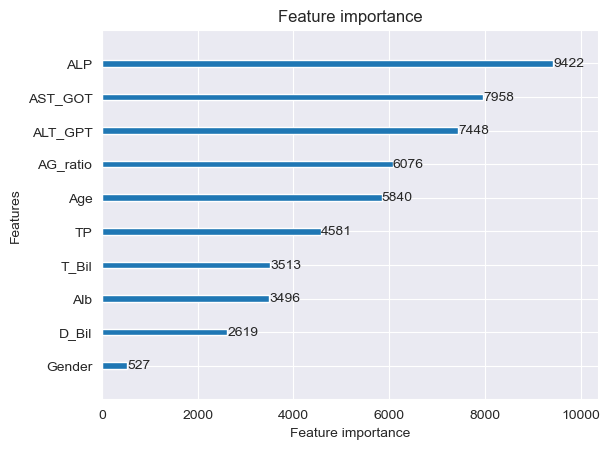

In [409]:
lgb.plot_importance(lgb_model_first)

In [411]:
submit = pd.DataFrame(train_data['disease'].iloc[len(train):])
submit['disease'] = y_pred
submit = submit.astype('int')
submit.to_csv('lgb_submit.csv', index=True, header=False)
submit

,disease
id,
891,0
892,1
893,0
894,1
895,0
896,1
897,0
898,0
899,0


In [143]:
# submission.csvの提出
# !signate submit --competition-id=1247 submission.csv --note LGB**51 # ここにコメント残せる